In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import pandas as pd
import h5py


In [57]:
class Reservoir:
  def __init__(self,Nr,D,rho,nbchan):
    self.Nr=Nr
    self.r=np.zeros(self.Nr)
    self.W=sc.random(self.Nr,self.Nr,density=float(D/self.Nr))
    self.W=rho/max(abs(np.linalg.eigvals(self.W.A)))*self.W
    self.W=(2*self.W-(self.W!=0))
    self.nbchan=nbchan
    self.Win=sc.random(self.Nr,nbchan,density=float(1))
    self.Win=(2*self.Win-(self.Win!=0))
  def step(self,input):
    self.r=(1-self.aleak)*self.r+self.aleak*np.tanh(self.bias+self.r@self.W+self.gamma*self.Win@input)
  def snapshots(self,aleak,gamma,biasscale,inputs,snap):
    L=list()
    self.bias=biasscale*2*(np.random.rand(self.Nr))-1
    self.aleak,self.gamma=aleak,gamma
    s=inputs.shape
    if s[1]!=self.nbchan:
      print('nb of channel conflict with inputs dim : reinitialize the reservoir with the right nbchan or change input accodingly')
    indexsnap=int(s[0]/snap)
    for i in range(s[0]):
      self.step(inputs[i])
      if i>0 and i%indexsnap==0:
        L.append(self.r)
    return np.array(L)
  def main(self,aleak,gamma,biasscale,snap,sinputs):
    Lmain=list()
    for inputs in sinputs:
      self.r=np.zeros(self.Nr)
      Lmain.append(self.snapshots(aleak,gamma,biasscale,inputs.T,snap))
    return np.array(Lmain)



    

In [4]:
x=np.linspace(0,10,100)
inputs=np.array([np.cos(x)+np.random.rand(x.size),np.sin(x)+np.random.rand(x.size)])


In [5]:
print(inputs.shape)

(2, 100)


In [6]:
Res=Reservoir(100,15,0.9,2)
print(Res.r)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [7]:
R3=Res.snapshots(0.2,1,1,inputs.T,20)

In [8]:
R3.shape

(19, 100)

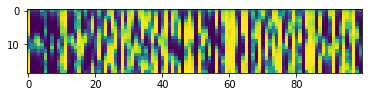

In [9]:
plt.imshow(R3)

In [10]:
sinputs=np.array([inputs,inputs,inputs,inputs])
R4=Res.main(0.2,1,1,20,sinputs)

In [11]:
R4.shape

(4, 19, 100)

In [13]:
filename = "X_train/X_train.h5"
eeg1 = pd.DataFrame(np.array(h5py.File(filename)['eeg_1']))
eeg2 = pd.DataFrame(np.array(h5py.File(filename)['eeg_2']))

<ipython-input-13-031a4554d4a5>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  eeg1 = pd.DataFrame(np.array(h5py.File(filename)['eeg_1']))
<ipython-input-13-031a4554d4a5>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  eeg2 = pd.DataFrame(np.array(h5py.File(filename)['eeg_2']))


In [14]:
data=np.zeros((24688,2,1500))
data[:,0,:]=eeg1
data[:,1,:]=eeg2

In [15]:
del eeg1
del eeg2

In [31]:
filename='y_train.csv'

ytrain=np.array(pd.read_csv(filename))
ytrain=ytrain[:,1]

In [17]:
data.shape

(24688, 2, 1500)

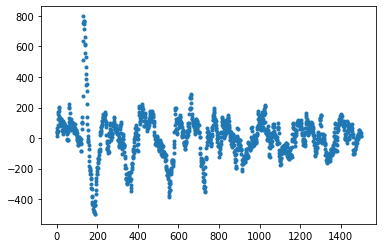

In [79]:
plt.plot(data[200,0,:],'.')

In [82]:
Res=Reservoir(100,15,0.9,2)

In [83]:
R4=Res.main(0.01,1,0.5,4,data[:500])

In [84]:
R4.shape

(500, 3, 100)

In [85]:
R4=np.reshape(R4,(R4.shape[0],R4.shape[1]*R4.shape[2]))

In [86]:
R4.shape

(500, 300)

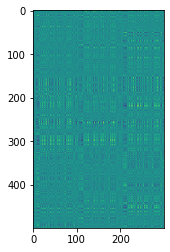

In [87]:
plt.imshow(R4)

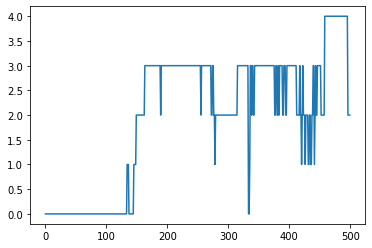

In [88]:
plt.plot(ytrain[:500])

In [45]:
from sklearn.linear_model import LogisticRegression

(array([144.,   0.,  16.,   0.,   0., 100.,   0., 202.,   0.,  38.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

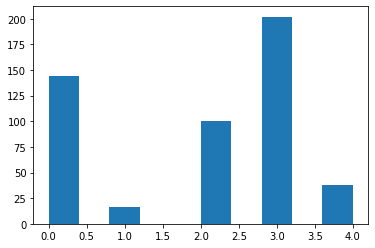

In [80]:
plt.hist(ytrain[:500])

(array([3511.,    0., 1671.,    0.,    0., 9449.,    0., 5224.,    0.,
        4833.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

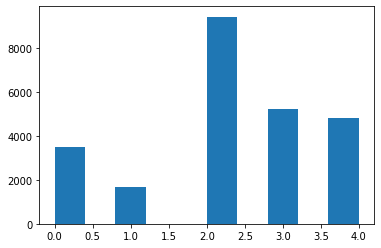

In [48]:
plt.hist(ytrain)

In [89]:
shuffler = np.random.permutation(R4.shape[0])  #toutes les données sont ordonées. Mieux vaut les mélanger pour le K-fold
R4s=R4[shuffler]
ytrains=ytrain[shuffler]

In [92]:

clf = LogisticRegression(random_state=0,class_weight='balanced',solver='liblinear',dual=True,max_iter=1000).fit(R4s[:400], ytrains[:400])
print(clf.score(R4s,ytrains[:500]))
print(clf.score(R4s[450:],ytrains[450:500]))


0.534
0.46


In [91]:
clf = LogisticRegression(random_state=0,class_weight='balanced',max_iter=1000).fit(R4s[:400], ytrains[:400])
print(clf.score(R4s,ytrains[:500]))
print(clf.score(R4s[450:],ytrains[450:500]))

0.458
0.4
